# Code 3

## Previous on Code 01 - 02

In [7]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [8]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, n_iter=1)
doc_stream = stream_docs(path='movie_data.csv')

/Users/sebastian/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [9]:
import pyprind
pbar = pyprind.ProgBar(45)


classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:27


In [10]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.867


In [11]:
clf = clf.partial_fit(X_test, y_test)

<br>
<br>

## Serializing fitted scikit-learn estimators

In [12]:
import pickle
import os

dest = os.path.join('movieclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

Next, we save the `HashingVectorizer` as in a separate file so that we can import it later.

In [13]:
%%writefile movieclassifier/vectorizer.py
from sklearn.feature_extraction.text import HashingVectorizer
import re
import os
import pickle

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(
                os.path.join(cur_dir, 
                'pkl_objects', 
                'stopwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) \
                   + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Overwriting movieclassifier/vectorizer.py


In [14]:
import os
os.chdir('movieclassifier')

In [15]:
import pickle
import re
import os
from vectorizer import vect

clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

In [16]:
import numpy as np
label = {0:'negative', 1:'positive'}

example = ['I love this movie']
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[clf.predict(X)[0]], 
       np.max(clf.predict_proba(X))*100))

Prediction: positive
Probability: 82.52%


<br>
<br>

## Setting up a SQLite database for data storage

In [17]:
import sqlite3
import os

if os.path.exists('reviews.sqlite'):
    os.remove('reviews.sqlite')

conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()
c.execute('CREATE TABLE review_db (review TEXT, sentiment INTEGER, date TEXT)')

example1 = 'I love this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example1, 1))

example2 = 'I disliked this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example2, 0))

conn.commit()
conn.close()

In [18]:
conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

c.execute("SELECT * FROM review_db WHERE date BETWEEN '2017-01-01 10:10:10' AND DATETIME('now')")
#전체결과 불러오기
results = c.fetchall()

conn.close()

In [19]:
print(results)

[('I love this movie', 1, '2017-08-21 19:00:44'), ('I disliked this movie', 0, '2017-08-21 19:00:44')]


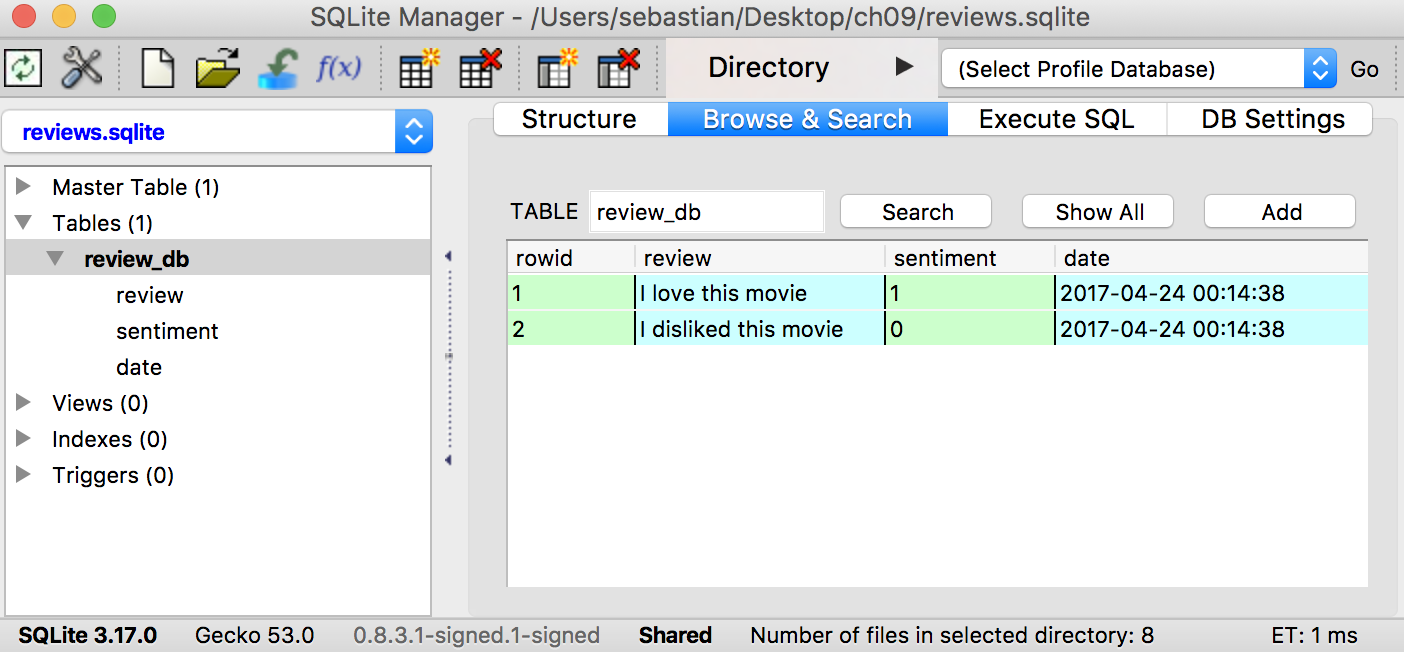

In [20]:
Image(filename='../images/09_01.png', width=700) 

<br>

## Updating the movie review classifier

Change current directory to `movieclassifier`:

Define a function to update the classifier with the data stored in the local SQLite database:

In [30]:
import pickle
import sqlite3
import numpy as np

# import HashingVectorizer from local dir
from vectorizer import vect

def update_model(db_path, model, batch_size=10000):

    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute('SELECT * from review_db')
    
    results = c.fetchmany(batch_size)
    while results:
        data = np.array(results)
        X = data[:, 0]
        y = data[:, 1].astype(int)
    
        classes = np.array([0, 1])
        X_train = vect.transform(X)
        clf.partial_fit(X_train, y, classes=classes)
        #특정 개수만큼 결과값 불러오기
        results = c.fetchmany(batch_size)
    
    conn.close()
    return None

In [31]:
cur_dir = '.'

clf = pickle.load(open(os.path.join(cur_dir,
                 'pkl_objects',
                 'classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')

update_model(db_path=db, model=clf, batch_size=10000)